In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import itertools
from tqdm import tqdm
import random
import multiprocessing

In [2]:
def get_df():
    df = pd.read_parquet('data.parquet', engine='pyarrow')
    cols = ['time', 'close']
    df = df[cols]
    return df

In [3]:
def add_sma(df, SMA_short, SMA_long):
    
    df["SMA_short"] = ta.sma(df['close'], SMA_short)
    df["SMA_long"] = ta.sma(df['close'], SMA_long)
        
    df = df.dropna().reset_index(drop=True)
    
    return df

In [4]:
def add_signals(df):
    buy_condition = (df['SMA_short'] >= df['SMA_long']) & (df['SMA_short'].shift(1) < df['SMA_long'].shift(1))
    sell_condition = (df['SMA_short'] < df['SMA_long']) & (df['SMA_short'].shift(1) >= df['SMA_long'].shift(1))

    df['signals_buy'] = df.loc[buy_condition, 'close']
    df['signals_sell'] = df.loc[sell_condition, 'close']

    return df

In [5]:
def evaluate_signals(df):

    buys = df["signals_buy"].dropna()
    sells = df["signals_sell"].dropna()
    
    # TODO is overall_profit_multiplier calculated properly?
    return {
        "profit_multiplier": sells.mean() / buys.mean(),
        "buy_sell_trade_pair_count": (buys.count() + sells.count()) / 2,
        "overall_profit_multiplier": (sells.mean() / buys.mean() - 1) * (buys.count() + sells.count()) / 2 + 1
    }

In [6]:
SMA_values = list(range(2,60, 1))
sma_combinations = list(itertools.product(SMA_values, SMA_values))

# skip same value pairs
sma_combinations = [(short, long) for (short, long) in sma_combinations if short != long]
# sma_combinations = random.choices(sma_combinations, k = min(len(sma_combinations), 2000))

len(sma_combinations)

3306

In [7]:
df_raw = get_df()

def calculate_result(sma_pair):
    sma_short, sma_long = sma_pair
    
    df = add_signals(add_sma(df_raw, sma_short, sma_long))
    
    result = {
        "SMA_short": sma_short,
        "SMA_long": sma_long
    }
    
    result.update(evaluate_signals(df))
    
    return result

In [8]:
with multiprocessing.Pool() as pool:
    results_list = []
    for result in tqdm(pool.imap_unordered(calculate_result, sma_combinations), total=len(sma_combinations)):
        results_list.append(result)
        
results = pd.DataFrame(results_list)

100%|██████████| 3306/3306 [10:09<00:00,  5.42it/s]


In [11]:
pd.options.display.float_format = '{:.20f}'.format

In [12]:
results.nlargest(5, 'profit_multiplier')

,SMA_short,SMA_long,profit_multiplier,buy_sell_trade_pair_count,overall_profit_multiplier
1901,35,23,1.00024827821255168914,53073.00000000000000000000,14.17686957475579845322
1845,34,23,1.00024468449142833748,55455.00000000000000000000,14.56897847215845587243
1958,36,23,1.00023975459854863601,50965.00000000000000000000,13.21909311503123518605
1787,33,22,1.00023975024495648256,56637.00000000000000000000,14.57873462360030281104
1959,36,22,1.00023824577289710547,50182.00000000000000000000,12.95564937552254747288


In [13]:
results.nlargest(5, 'buy_sell_trade_pair_count')

,SMA_short,SMA_long,profit_multiplier,buy_sell_trade_pair_count,overall_profit_multiplier
58,3,2,1.00002999179207474612,563903.50000000000000000000,17.91247652222159558733
7,2,3,0.99997060783232782910,563660.50000000000000000000,-15.56720392617968684590
116,4,3,1.00002710711240339059,471344.50000000000000000000,13.77678834221993398046
60,3,4,0.99997341017783403228,471173.50000000000000000000,-11.52841957431659380973
173,5,4,1.00002589504198380332,413478.00000000000000000000,11.70703016937903129246


In [14]:
results.nlargest(5, 'overall_profit_multiplier')

,SMA_short,SMA_long,profit_multiplier,buy_sell_trade_pair_count,overall_profit_multiplier
460,10,8,1.00008655927825662602,215165.00000000000000000000,19.62452710608693706718
463,10,9,1.00006400447327226111,285875.00000000000000000000,19.29727879670764423281
517,11,7,1.00010680406105745277,163636.50000000000000000000,18.47704273722786894041
462,10,7,1.00009256917909095108,188055.50000000000000000000,18.40814325853835242697
519,11,8,1.00009756266809368697,176689.50000000000000000000,18.23829904413950231401


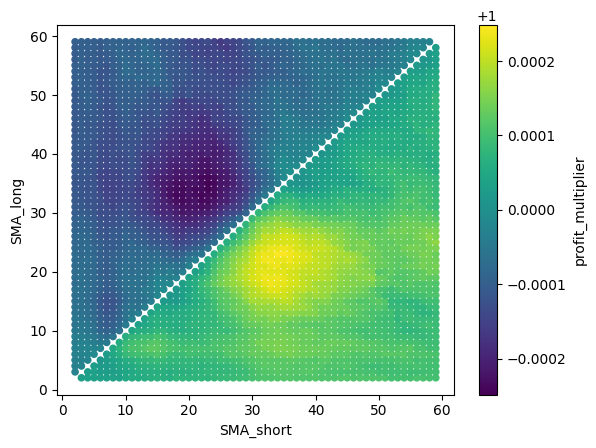

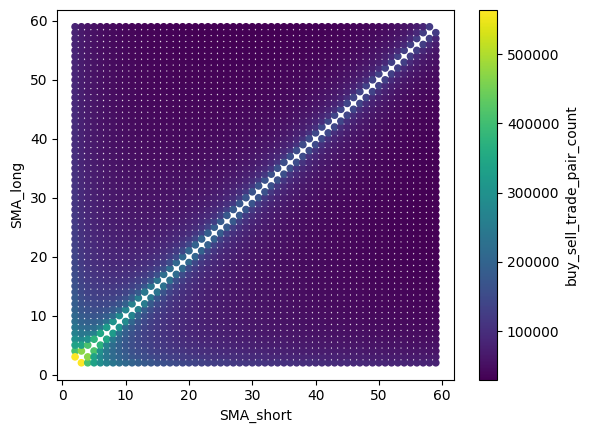

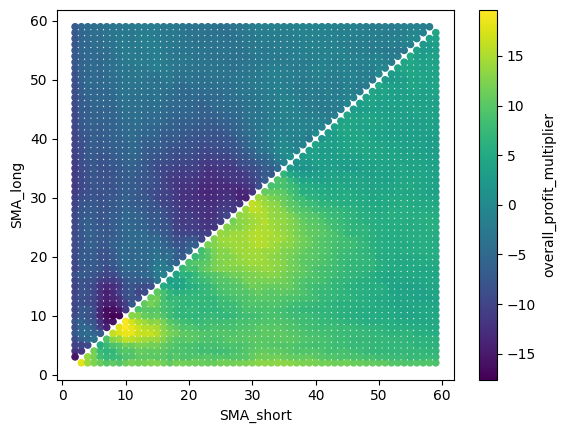

In [15]:
ax = results.plot(x="SMA_short", y="SMA_long", kind="scatter", c="profit_multiplier", colormap="viridis")
ax = results.plot(x="SMA_short", y="SMA_long", kind="scatter", c="buy_sell_trade_pair_count", colormap="viridis")
ax = results.plot(x="SMA_short", y="SMA_long", kind="scatter", c="overall_profit_multiplier", colormap="viridis")